In [1]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFECV, RFE, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(display='diagram')
from sklearn.svm import SVC
import datetime
from sklearn.ensemble import StackingClassifier

import shap

In [2]:
#imports
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import f1_score

In [3]:
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  classification_report
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [4]:
import eli5

# Carregamento dos dados

In [5]:
data = pd.read_csv('../../../../data/processed/(CORRIGIDO)ep2_pln_train_pos_pt_core_news_lg.xlsx')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

req_text age  \
0  - Quantos empregados em cada um dos atuais nív...  a2   
1  - Solicito cópia das Atas do Conselho de Admin...  a2   
2  - Solicito informar a norma (lei, decreto, por...  a2   
3  - Solicito por gentileza, a informação sobre a...  a2   
4  - Solicito por gentileza, a informação sobre a...  a2   

                                                 pos  
0  PUNCT DET NOUN ADP DET NUM ADP ADJ NOUN ADJ PU...  
1  PUNCT VERB NOUN ADP PROPN ADP PROPN ADP NOUN A...  
2  PUNCT VERB VERB DET NOUN PUNCT NOUN PUNCT NOUN...  
3  PUNCT VERB ADP NOUN PUNCT DET NOUN ADP DET NOU...  
4  PUNCT VERB ADP NOUN PUNCT DET NOUN ADP DET NOU...

In [6]:
data['age'] = data['age'].map({
                                'a4':3,
                                'a3': 2,
                                'a2': 1,
                                'a1': 0})

In [7]:
data.head()

req_text  age  \
0  - Quantos empregados em cada um dos atuais nív...    1   
1  - Solicito cópia das Atas do Conselho de Admin...    1   
2  - Solicito informar a norma (lei, decreto, por...    1   
3  - Solicito por gentileza, a informação sobre a...    1   
4  - Solicito por gentileza, a informação sobre a...    1   

                                                 pos  
0  PUNCT DET NOUN ADP DET NUM ADP ADJ NOUN ADJ PU...  
1  PUNCT VERB NOUN ADP PROPN ADP PROPN ADP NOUN A...  
2  PUNCT VERB VERB DET NOUN PUNCT NOUN PUNCT NOUN...  
3  PUNCT VERB ADP NOUN PUNCT DET NOUN ADP DET NOU...  
4  PUNCT VERB ADP NOUN PUNCT DET NOUN ADP DET NOU...

In [8]:
# a seguir os dados serão divididos entre features (X) e label (y)
X_text = data['req_text'] # features
y = data['age'] # label

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42,
                                                   stratify=y)

# Declaração do classificador

In [10]:
best_params = {'vect__ngram_range': (1, 3),
               'selection__percentile': 100,
               'estimator__fit_prior': False,
               'estimator__alpha': 0.3}

In [11]:
# define o pipeline
pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('scaling', MaxAbsScaler()), 
        ('selection', SelectPercentile()),
        ('ros', RandomOverSampler(random_state=42)),
        ('estimator', MultinomialNB())
        ])

In [12]:
clf = pipeline.set_params(**best_params)

In [13]:
clf.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('scaling', MaxAbsScaler()),
                ('selection', SelectPercentile(percentile=100)),
                ('estimator', MultinomialNB(alpha=0.3, fit_prior=False))])>

In [14]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('scaling', MaxAbsScaler()),
                ('selection', SelectPercentile(percentile=100)),
                ('estimator', MultinomialNB(alpha=0.3, fit_prior=False))])

# Interpretabilidade

## Interpretação global

### Features preditivas mais relevantes

In [15]:
def show_most_informative_features(n=20):
    vectorizer = clf['vect']
    classifier = clf['estimator']
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print ("\tfeatures preditivas menos relevantes\tfeatures preditivas mais relevantes")
    print ("\t------------------------------------\t------------------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [16]:
show_most_informative_features()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


	features preditivas menos relevantes	features preditivas mais relevantes
	------------------------------------	------------------------------------
	-13.7052	00 000         		-6.9856	de             
	-13.7052	00 000 00      		-7.1112	boa            
	-13.7052	00 0000        		-7.3714	gostaria       
	-13.7052	00 0000 df     		-7.4281	para           
	-13.7052	00 00091       		-7.4365	gostaria de    
	-13.7052	00 00091 006677		-7.6178	tarde          
	-13.7052	00 04parcelas  		-7.6239	boa tarde      
	-13.7052	00 04parcelas de		-7.6257	do             
	-13.7052	00 150         		-7.6675	da             
	-13.7052	00 150 00      		-7.7278	no             
	-13.7052	00 16          		-7.8663	em             
	-13.7052	00 16 20       		-7.8763	que            
	-13.7052	00 180         		-7.8920	de saber       
	-13.7052	00 180 00      		-7.9077	gostaria de saber
	-13.7052	00 20          		-7.9559	na             
	-13.7052	00 20 36       		-7.9949	noite          
	-13.7052	00 20 45       		-7.99

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


In [17]:
def make_predictions(X_test):
    
    preds = clf.predict(X_test)
    
    return preds

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker)

shap_values_global = explainer(X_text)

PartitionExplainer explainer:   1%|▍                                               | 72/8200 [04:04<7:59:11,  3.54s/it]


KeyboardInterrupt: 

In [ ]:
shap.plots.bar(shap_values.mean(0))

### Matriz de confusão

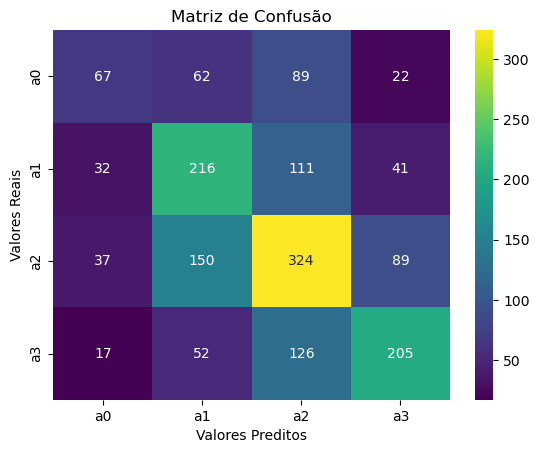

In [18]:
# Faça previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Crie a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Crie um heatmap usando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['a0', 'a1', 'a2', 'a3'],
            yticklabels=['a0', 'a1', 'a2', 'a3'])

plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

### Curva ROC

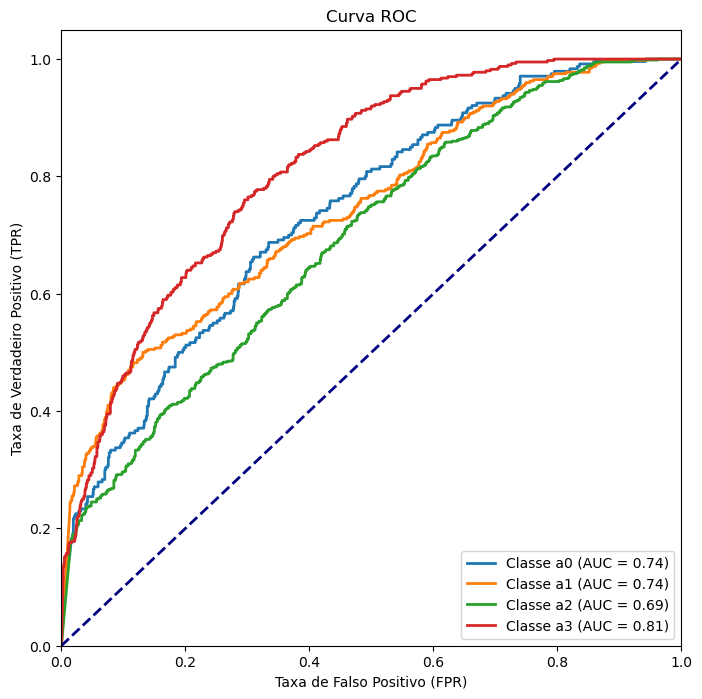

In [19]:
# Obtenha as probabilidades previstas para cada classe no conjunto de teste
y_score = clf.predict_proba(X_test)

# Binarize as classes para a construção da curva ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Calcule a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

classes = ['a0', 'a1', 'a2', 'a3']

# Plote a curva ROC para cada classe
plt.figure(figsize=(8, 8))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Classification Report

In [20]:
# Faça previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Gere e imprima o relatório de classificação
report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.44      0.28      0.34       240
           1       0.45      0.54      0.49       400
           2       0.50      0.54      0.52       600
           3       0.57      0.51      0.54       400

    accuracy                           0.50      1640
   macro avg       0.49      0.47      0.47      1640
weighted avg       0.50      0.50      0.49      1640



## Interpretação local

In [21]:
shap.initjs()

In [22]:
def make_predictions(X_text):
    
    preds = clf.predict(X_text)
        
    return preds
# ---------------------------------------------------------- SE FOR CHAR PRECISA MUDAR O TOKENIZER
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker)

In [23]:
amostra = X_test[0:20].reset_index(drop=True)
labels = y_test[0:20].reset_index(drop=True)
shap_values_local = explainer(amostra)

PartitionExplainer explainer: 21it [01:03,  3.74s/it]                                                                  


### Análise para cada classe

In [24]:
y_pred = clf.predict(amostra)
y_proba = clf.predict_proba(amostra)

In [25]:
y_pred = y_pred.astype(object)

In [26]:
y_pred[y_pred == 0] = 'a1'
y_pred[y_pred == 1] = 'a2'
y_pred[y_pred == 2] = 'a3'
y_pred[y_pred == 3] = 'a4'

In [27]:
labels[labels == 0] = 'a1'
labels[labels == 1] = 'a2'
labels[labels == 2] = 'a3'
labels[labels == 3] = 'a4'

In [28]:
y_pred

array(['a4', 'a2', 'a2', 'a2', 'a3', 'a3', 'a4', 'a3', 'a2', 'a3', 'a1',
       'a4', 'a3', 'a3', 'a2', 'a3', 'a3', 'a4', 'a2', 'a2'], dtype=object)

In [29]:
a1_idx = [i for i in range(len(y_pred)) if y_pred[i] == 'a1']
a2_idx = [i for i in range(len(y_pred)) if y_pred[i] == 'a2']
a3_idx = [i for i in range(len(y_pred)) if y_pred[i] == 'a3']
a4_idx = [i for i in range(len(y_pred)) if y_pred[i] == 'a4']

#### a1

In [30]:
for i in a1_idx:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a1
A label real era a3
As probabilidades foram [9.89939279e-01 5.66580790e-03 4.39490143e-03 1.15841639e-08]


--------------------------------------------------------------------------------------------------------------------


#### a2

In [31]:
for i in a2_idx:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a2
A label real era a2
As probabilidades foram [1.61916524e-12 9.98798225e-01 1.20177456e-03 6.39133610e-17]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [2.10391701e-10 9.99999999e-01 7.55155390e-10 1.29753600e-20]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a1
As probabilidades foram [5.82283752e-08 9.99999942e-01 2.11744246e-10 2.03022167e-31]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [2.31637569e-16 9.99619311e-01 1.64169252e-06 3.79046986e-04]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [4.47238201e-09 9.99999935e-01 6.08093848e-08 4.28869278e-13]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a2
As probabilidades foram [8.28008670e-13 9.09185762e-01 2.40918540e-08 9.08142143e-02]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a2
As probabilidades foram [3.07382053e-06 9.99928856e-01 6.80698832e-05 4.48109006e-24]


--------------------------------------------------------------------------------------------------------------------


#### a3

In [32]:
for i in a3_idx:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a3
A label real era a2
As probabilidades foram [4.78591969e-23 2.45832409e-20 1.00000000e+00 8.31950329e-16]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [8.52688716e-05 4.40203691e-03 9.95282710e-01 2.29984195e-04]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [1.11900012e-06 4.13607721e-11 9.99968532e-01 3.03485736e-05]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [2.14082394e-26 4.25658189e-17 9.99999983e-01 1.66606731e-08]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [1.80651684e-09 5.61011894e-12 9.99999998e-01 4.60712253e-15]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [6.04975338e-19 9.76176271e-20 1.00000000e+00 8.13749819e-24]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a2
As probabilidades foram [1.15874026e-05 6.97989816e-08 9.15896583e-01 8.40917593e-02]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [2.41866953e-15 2.14395208e-07 9.99607802e-01 3.91983328e-04]


--------------------------------------------------------------------------------------------------------------------


#### a4

In [33]:
for i in a4_idx:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a4
A label real era a3
As probabilidades foram [1.54745245e-16 3.86091059e-14 2.36761178e-11 1.00000000e+00]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a1
As probabilidades foram [4.77509536e-09 4.82139029e-02 8.75865525e-10 9.51786091e-01]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a3
As probabilidades foram [4.33375995e-14 1.59577974e-05 7.96279826e-04 9.99187762e-01]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a4
As probabilidades foram [1.10592273e-10 2.46904785e-06 7.96350882e-12 9.99997531e-01]


--------------------------------------------------------------------------------------------------------------------


## Análise de erros

In [34]:
acertos = [i for i in range(len(y_pred)) if y_pred[i] == labels[i]]
erros = [i for i in range(len(y_pred)) if y_pred[i] != labels[i]]

### Acertos

In [35]:
for i in acertos:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a2
A label real era a2
As probabilidades foram [1.61916524e-12 9.98798225e-01 1.20177456e-03 6.39133610e-17]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [8.52688716e-05 4.40203691e-03 9.95282710e-01 2.29984195e-04]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [6.04975338e-19 9.76176271e-20 1.00000000e+00 8.13749819e-24]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a3
As probabilidades foram [2.41866953e-15 2.14395208e-07 9.99607802e-01 3.91983328e-04]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a4
As probabilidades foram [1.10592273e-10 2.46904785e-06 7.96350882e-12 9.99997531e-01]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a2
As probabilidades foram [8.28008670e-13 9.09185762e-01 2.40918540e-08 9.08142143e-02]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a2
As probabilidades foram [3.07382053e-06 9.99928856e-01 6.80698832e-05 4.48109006e-24]


--------------------------------------------------------------------------------------------------------------------


### Erros

In [36]:
for i in erros:

    print(f'A predição foi {y_pred[i]}')
    print(f'A label real era {labels[i]}')
    print(f'As probabilidades foram {y_proba[i]}')
    shap.text_plot(shap_values_local[i])
    print('--------------------------------------------------------------------------------------------------------------------')

A predição foi a4
A label real era a3
As probabilidades foram [1.54745245e-16 3.86091059e-14 2.36761178e-11 1.00000000e+00]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [2.10391701e-10 9.99999999e-01 7.55155390e-10 1.29753600e-20]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a1
As probabilidades foram [5.82283752e-08 9.99999942e-01 2.11744246e-10 2.03022167e-31]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a2
As probabilidades foram [4.78591969e-23 2.45832409e-20 1.00000000e+00 8.31950329e-16]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a1
As probabilidades foram [4.77509536e-09 4.82139029e-02 8.75865525e-10 9.51786091e-01]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [1.11900012e-06 4.13607721e-11 9.99968532e-01 3.03485736e-05]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [2.31637569e-16 9.99619311e-01 1.64169252e-06 3.79046986e-04]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [2.14082394e-26 4.25658189e-17 9.99999983e-01 1.66606731e-08]


--------------------------------------------------------------------------------------------------------------------
A predição foi a1
A label real era a3
As probabilidades foram [9.89939279e-01 5.66580790e-03 4.39490143e-03 1.15841639e-08]


--------------------------------------------------------------------------------------------------------------------
A predição foi a4
A label real era a3
As probabilidades foram [4.33375995e-14 1.59577974e-05 7.96279826e-04 9.99187762e-01]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a4
As probabilidades foram [1.80651684e-09 5.61011894e-12 9.99999998e-01 4.60712253e-15]


--------------------------------------------------------------------------------------------------------------------
A predição foi a2
A label real era a3
As probabilidades foram [4.47238201e-09 9.99999935e-01 6.08093848e-08 4.28869278e-13]


--------------------------------------------------------------------------------------------------------------------
A predição foi a3
A label real era a2
As probabilidades foram [1.15874026e-05 6.97989816e-08 9.15896583e-01 8.40917593e-02]


--------------------------------------------------------------------------------------------------------------------


In [ ]:
shap.plots.bar(shap_values_local)